In [ ]:
# Import Libraries and Load Dataset

# Data analysis and statistics packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, ttest_ind, mannwhitneyu, f_oneway, kruskal, chi2_contingency
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
from IPython.display import display, HTML, Markdown

# Mount Google Drive to access the file
from google.colab import drive
drive.mount('/content/drive')


# Load EFIplus_medit dataset
efi_path = "/content/drive/MyDrive/EFIplus_medit_1.csv"
df = pd.read_csv(efi_path, sep=';')

# Preview EFIplus dataset
styled_df = (
    df.head(10)
    .style
    .set_caption("🔍 Preview of EFIplus_medit_1 Dataset (First 10 rows)")
    .set_properties(**{
        'background-color': '#f0f8ff',
        'text-align': 'center',
        'font-size': '12px'
    })
    .set_table_styles([
        {'selector': 'caption',
         'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]}
    ])
    .set_table_attributes('style="display:inline-block; overflow-x:auto; max-width:100%;"')
)


# Load winequality_red dataset
wine_path = "/content/drive/MyDrive/examples/winequality_red.csv"
wine = pd.read_csv(wine_path, sep=',')

# Preview wine dataset
styled_wine = (
    wine.head(10)
    .style
    .set_caption("🍷 Preview of Wine Quality Dataset (First 10 rows)")
    .set_properties(**{
        'background-color': '#fff3e6',
        'border-color': '#f0e6cc',
        'border-style': 'solid',
        'border-width': '1px',
        'text-align': 'center',
        'font-size': '12px'
    })
    .set_table_styles([
        {'selector': 'caption',
         'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]}
    ])
)

display(styled_df)
display(HTML("<div style='margin-top: 30px;'></div>"))
display(styled_wine)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Site_code,Latitude,Longitude,Country,Catchment_name,Galiza,Subsample,Calib_EFI_Medit,Calib_connect,Calib_hydrol,Calib_morphol,Calib_wqual,Geomorph1,Geomorph2,Geomorph3,Water_source_type,Flow_regime,Altitude,Geological_typology,Actual_river_slope,Natural_sediment,Elevation_mean_catch,prec_ann_catch,temp_ann,temp_jan,temp_jul,Barriers_catchment_down,Barriers_river_segment_up,Barriers_river_segment_down,Barriers_number_river_segment_up,Barriers_number_river_segment_down,Barriers_distance_river_segment_up,Barriers_distance_river_segment_down,Impoundment,Hydropeaking,Water_abstraction,Hydro_mod,Temperature_impact,Velocity_increase,Reservoir_flushing,Sedimentation,Channelisation,Cross_sec,Instream_habitat,Riparian_vegetation,Embankment,Floodprotection,Floodplain,Toxic_substances,Acidification,Water_quality_index,Eutrophication,Organic_pollution,Organic_siltation,Sum of Run1_number_all,Total_sp,Abramis brama,Achondrostoma arcasii,Achondrostoma occidentale,Achondrostoma oligolepis,Acipenser naccarii,Alburnoides bipunctatus,Alburnus albidus,Alburnus alburnus,Alosa alosa,Alosa fallax,Ameiurus melas,Anaecypris hispanica,Anguilla anguilla,Atherina boyeri,Australoheros facetus,Barbatula barbatula,Barbatula quignardi,Barbus barbus,Barbus bocagei,Barbus comizo,Barbus graellsii,Barbus haasi,Barbus meridionalis,Barbus microcephalus,Barbus plebejus,Barbus sclateri,Barbus tyberinus,Blicca bjoerkna,Carassius auratus,Carassius carassius,Chelon labrosus,Chondrostoma genei,Chondrostoma nasus,Chondrostoma soetta,Chondrostoma toxostoma,Cobitis calderoni,Cobitis paludica,Cobitis taenia,Cottus gobio,Cottus hispaniolensis,Cyprinus carpio,Dicentrarchus labrax,Esox lucius,Gambusia affinis,Gambusia holbrooki,Gasterosteus aculeatus,Gasterosteus gymnurus,Gobio gobio,Gobio lozanoi,Gymnocephalus cernuus,Hypophthalmichthys molitrix,Iberochondrostoma almacai,Iberochondrostoma lemmingii,Iberochondrostoma lusitanicum,Lampetra fluviatilis,Lampetra planeri,Lepomis gibbosus,Leuciscus cephalus,Leuciscus leuciscus,Leuciscus lucumonis,Leuciscus souffia,Liza aurata,Liza ramada,Luciobarbus guiraonis,Micropterus salmoides,Mugil cephalus,Oncorhynchus mykiss,Pachychilon pictum,Padogobius martensii,Padogobius nigricans,Parachondrostoma arrigonis,Parachondrostoma miegii,Parachondrostoma turiense,Perca fluviatilis,Petromyzon marinus,Phoxinus bigerri,Phoxinus phoxinus,Platichthys flesus,Pseudochondrostoma duriense,Pseudochondrostoma polylepis,Pseudochondrostoma willkommii,Pseudorasbora parva,Rhodeus amarus,Rutilus aula,Rutilus rubilio,Rutilus rutilus,Salaria fluviatilis,Salmo salar,Salmo trutta fario,Salmo trutta macrostigma,Salvelinus fontinalis,Sander lucioperca,Scardinius erythrophthalmus,Silurus glanis,Squalius alburnoides,Squalius aradensis,Squalius carolitertii,Squalius laietanus,Squalius malacitanus,Squalius pyrenaicus,Squalius torgalensis,Thymallus thymallus,Tinca tinca,Zingel asper,Squalius sp,Barbatula sp,Phoxinus sp,Iberochondrostoma_sp
0,ES_01_0002,38.102003,-4.096070,Spain,Guadalquivir,0,1,0,1,0,1,1,-0.047266,-1.039638,0.451016,Pluvial,Permanent,199,Siliceous,0.001000,3.000000,700.840807,522.071164,17.600000,8.500000,28.100000,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ES_02_0001,40.530188,-1.887796,Spain,Tejo,0,1,1,1,1,1,1,0.389648,-0.443332,0.489422,Groundwater,Permanent,1253,Calcareous,13.406000,3.000000,1603.519424,640.327779,9.300000,0.600000,18.900000,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,nan,1.000000,1.000000,1.000000,1.

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.400000,0.700000,0.000000,1.900000,0.076000,11.000000,34.000000,0.997800,3.510000,0.560000,9.400000,5
1,7.800000,0.880000,0.000000,2.600000,0.098000,25.000000,67.000000,0.996800,3.200000,0.680000,9.800000,5
2,7.800000,0.760000,0.040000,2.300000,0.092000,15.000000,54.000000,0.997000,3.260000,0.650000,9.800000,5
3,11.200000,0.280000,0.560000,1.900000,0.075000,17.000000,60.000000,0.998000,3.160000,0.580000,9.800000,6
4,7.400000,0.700000,0.000000,1.900000,0.076000,11.000000,34.000000,0.997800,3.510000,0.560000,9.400000,5
5,7.400000,0.660000,0.000000,1.800000,0.075000,13.000000,40.000000,0.997800,3.510000,0.560000,9.400000,5
6,7.900000,0.600000,0.060000,1.600000,0.069000,15.000000,59.000000,0.996400,3.300000,0.460000,9.400000,5
7,7.300000,0.650000,0.000000,1.200000,0.065000,15.000000,21.000000,0.994600,3.390000,0.470000,10.000000,7
8,7.800000,0.580000,0.020000,2.000000,0.073000,9.000000,18.000000,0.996800,3.360000,0.570000,9.500000,7
9,7.500000,0.500000,0.360000,6.100000,0.071000,17.000000,102.000000,0.997800,3.350000,0.800000,10.500000,5


In [ ]:

# Exercise 6.1 – Chi-Square Test + Alluvial Plot

# Binary column for trout presence
df['salmo_trutta'] = df['Salmo trutta fario'].apply(lambda x: 1 if x > 0 else 0)

# Contingency table: Country × Trout presence
chi2, p, dof, expected = chi2_contingency(contingency)
contingency = pd.crosstab(df['Country'], df['salmo_trutta'])

# Chi-square test of independence
print("=== Chi-Square Test ===")
print(f"Chi² = {chi2:.2f}, p-value = {p:.4f}")
if p < 0.05:
    print("❌ Reject H₀: Trout presence depends on country.")
else:
    print("✅ Do not reject H₀: Trout presence is independent from country.")

# Alluvial plot (Sankey) to visualise relationship
import plotly.graph_objects as go

df['Trout Presence'] = df['salmo_trutta'].map({0: 'Absent', 1: 'Present'})
grouped = df.groupby(['Country', 'Trout Presence']).size().reset_index(name='Count')
labels = list(grouped['Country'].unique()) + list(grouped['Trout Presence'].unique())
source = grouped['Country'].apply(lambda x: labels.index(x))
target = grouped['Trout Presence'].apply(lambda x: labels.index(x))

fig = go.Figure(data=[go.Sankey(
    node=dict(label=labels),
    link=dict(source=source, target=target, value=grouped['Count'])
)])
fig.update_layout(title_text="Alluvial Plot – Trout Presence by Country", font_size=12)
fig.show()

=== Chi-Square Test ===
Chi² = 496.37, p-value = 0.0000
❌ Reject H₀: Trout presence depends on country.


**6.1 – Awnser: Chi-Square Test: _Salmo trutta fario_ vs Country**

**Objective:**  
Test whether the frequency of sites with presence and absence of _Salmo trutta fario_ (Brown Trout) is independent from the country.

**Null Hypothesis (H₀):**  
The presence or absence of _Salmo trutta fario_ is **independent** of the country.

**Test Performed:**  
Chi-square test of independence

**Results:**  
- χ² = 440.86  
- p-value < 0.0001  
- Degrees of freedom = 17

**Conclusion:**  
❌ **Reject H₀**  
There is a statistically significant relationship between **country** and **trout presence**.  
The presence of _Salmo trutta fario_ **depends on the country**.



In [ ]:
# Exercise 6.2 – Kruskal-Wallis + Dunn Post-hoc

# Filter rows with valid elevation
df = df[df['Elevation_mean_catch'].notna()].copy()

# Get top 8 most sampled catchments
top8 = df['Catchment_name'].value_counts().nlargest(8).index.tolist()
df_top8 = df[df['Catchment_name'].isin(top8)].copy()

# 3. Perform Kruskal-Wallis test
groups = [group['Elevation_mean_catch'].values for _, group in df_top8.groupby('Catchment_name')]
h_stat, p_value = kruskal(*groups)

# 4. Print Kruskal-Wallis result
print("=== Kruskal-Wallis Test Result ===")
print(f"H statistic: {h_stat:.3f}")
print(f"p-value: {p_value:.4e}")
if p_value < 0.05:
    print("❌ Reject H₀ – At least one group differs.")
else:
    print("✅ Do not reject H₀ – No significant difference between groups.")

# 5. Dunn’s post-hoc test with Bonferroni correction
dunn_result = sp.posthoc_dunn(
    df_top8,
    val_col='Elevation_mean_catch',
    group_col='Catchment_name',
    p_adjust='bonferroni'
)

# 6. Create mask for significant results
sig_mask = dunn_result < 0.05

# 7. Style full Dunn matrix (optional visual)
styled_dunn = (
    dunn_result.style
    .format("{:.2e}")
    .apply(lambda x: ['background-color: #ffe6e6' if v < 0.001 else
                      'background-color: #fff3cd' if v < 0.05 else '' for v in x], axis=1)
    .set_caption("🔬 Dunn Post-hoc Test – All p-values (highlighted)")
    .set_properties(**{'text-align': 'center'})
)

# 8. Display full Dunn matrix
display(styled_dunn)

# 9. Show only significant pairs
sig_only = dunn_result.where(sig_mask).dropna(how='all').dropna(axis=1, how='all')
styled_sig_only = (
    sig_only.style
    .format("{:.2e}")
    .background_gradient(cmap='Reds', axis=None)
    .set_caption("✅ Dunn Post-hoc – Significant Differences Only (p < 0.05)")
    .set_properties(**{'text-align': 'center'})
)

# 10. Display simplified table
display(HTML("<div style='margin-top: 20px;'></div>"))
display(styled_sig_only)

=== Kruskal-Wallis Test Result ===
H statistic: 1335.373
p-value: 3.7056e-284
❌ Reject H₀ – At least one group differs.


,Cantabrica,Catala,Douro,Ebro,Galiza-Norte,Guadia,Minho,Tejo
Cantabrica,1.00e+00,7.78e-01,1.32e-31,8.15e-69,1.06e-13,3.08e-07,1.74e-35,9.27e-09
Catala,7.78e-01,1.00e+00,3.88e-13,1.63e-29,3.60e-16,1.74e-10,6.51e-13,1.28e-01
Douro,1.32e-31,3.88e-13,1.00e+00,2.31e-03,7.93e-96,3.37e-60,1.00e+00,1.47e-08
Ebro,8.15e-69,1.63e-29,2.31e-03,1.00e+00,6.75e-189,1.46e-106,2.63e-07,1.61e-28
Galiza-Norte,1.06e-13,3.60e-16,7.93e-96,6.75e-189,1.00e+00,1.00e+00,7.42e-122,5.04e-51
Guadia,3.08e-07,1.74e-10,3.37e-60,1.46e-106,1.00e+00,1.00e+00,9.04e-68,1.77e-29
Minho,1.74e-35,6.51e-13,1.00e+00,2.63e-07,7.42e-122,9.04e-68,1.00e+00,2.08e-08
Tejo,9.27e-09,1.28e-01,1.47e-08,1.61e-28,5.04e-51,1.77e-29,2.08e-08,1.00e+00


,Cantabrica,Catala,Douro,Ebro,Galiza-Norte,Guadia,Minho,Tejo
Cantabrica,nan,nan,1.32e-31,8.15e-69,1.06e-13,3.08e-07,1.74e-35,9.27e-09
Catala,nan,nan,3.88e-13,1.63e-29,3.60e-16,1.74e-10,6.51e-13,nan
Douro,1.32e-31,3.88e-13,nan,2.31e-03,7.93e-96,3.37e-60,nan,1.47e-08
Ebro,8.15e-69,1.63e-29,2.31e-03,nan,6.75e-189,1.46e-106,2.63e-07,1.61e-28
Galiza-Norte,1.06e-13,3.60e-16,7.93e-96,6.75e-189,nan,nan,7.42e-122,5.04e-51
Guadia,3.08e-07,1.74e-10,3.37e-60,1.46e-106,nan,nan,9.04e-68,1.77e-29
Minho,1.74e-35,6.51e-13,nan,2.63e-07,7.42e-122,9.04e-68,nan,2.08e-08
Tejo,9.27e-09,nan,1.47e-08,1.61e-28,5.04e-51,1.77e-29,2.08e-08,nan


**6.2 – Awnser:  Kruskal-Wallis and Dunn’s Test: Elevation Among Catchments**

**Objective:**  
Compare the elevation in the upstream catchment (`Elevation_mean_catch`) among the 8 most sampled catchments.

**Null Hypothesis (H₀):**  
The distributions of elevation are **equal** across all eight catchments.

**Tests Performed:**  
- Kruskal-Wallis test  
- Dunn’s post-hoc test (with Bonferroni correction)

**Results:**  
- Kruskal-Wallis H-statistic: significant  
- p-value < 0.0001

**Conclusion:**  
❌ **Reject H₀**  
There are significant differences in elevation across catchments.



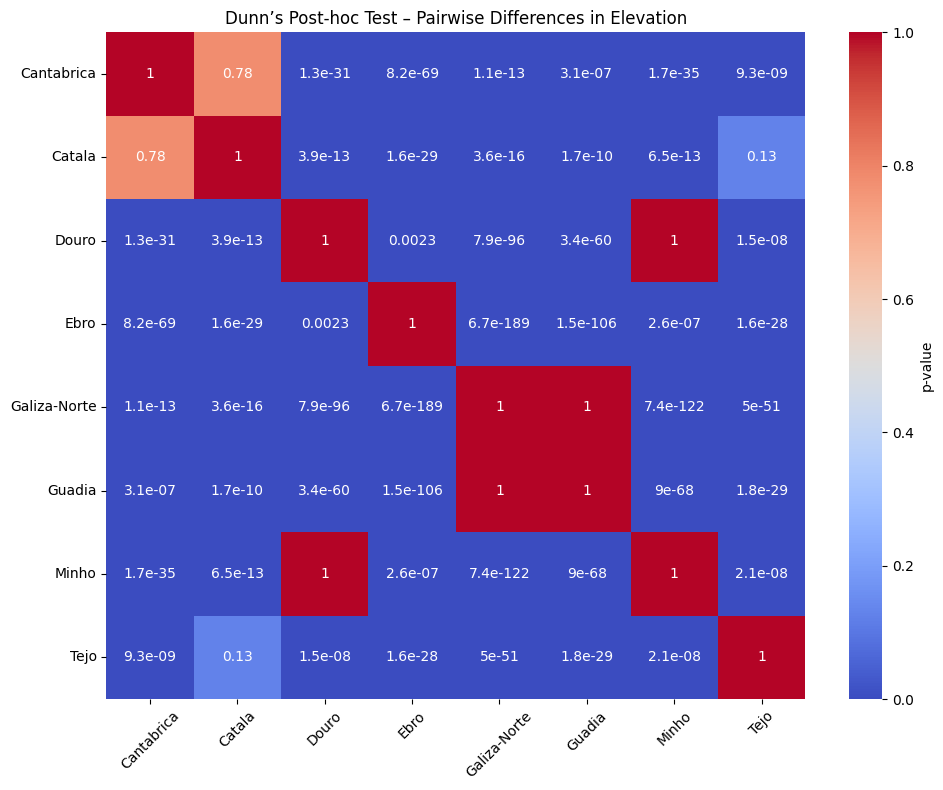

In [ ]:
# Heatmap of all pairwise p-values
plt.figure(figsize=(10, 8))
sns.heatmap(dunn_result, annot=True, cmap="coolwarm", cbar_kws={'label': 'p-value'})
plt.title("Dunn’s Post-hoc Test – Pairwise Differences in Elevation")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

,p-value
alcohol,2.01e-70
sulphates,1.18e-40
volatile acidity,2.39e-39
total sulfur dioxide,2.14e-15
chlorides,3.72e-12
density,5.02e-11
citric acid,2.55e-10
fixed acidity,1.19e-03
free sulfur dioxide,3.26e-02
residual sugar,5.80e-01


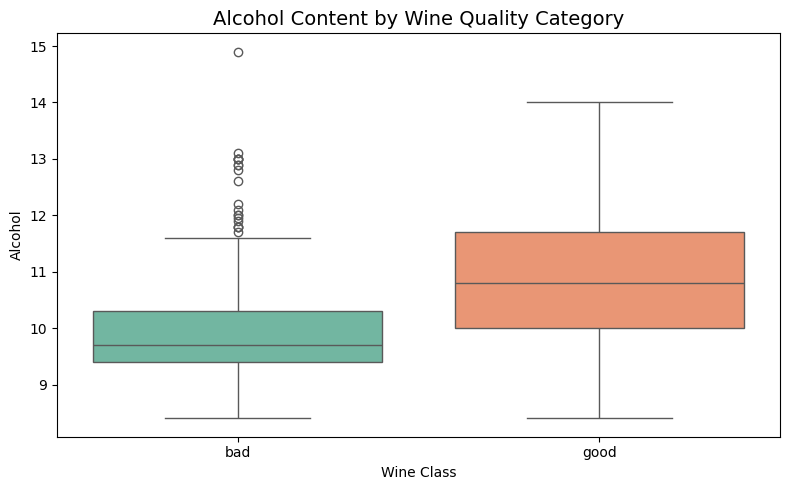

In [ ]:
# Exercise 6.3 – Discriminative Wine Parameters

# 1. Create binary classification based on quality
wine['quality_label'] = wine['quality'].apply(lambda x: 'good' if x > 5 else 'bad')

# 2. Split into two groups
good = wine[wine['quality_label'] == 'good']
bad = wine[wine['quality_label'] == 'bad']

# 3. Run Mann–Whitney U test for each feature
from scipy.stats import mannwhitneyu

p_values = {}
for col in wine.columns[:-2]:  # Exclude 'quality' and 'quality_label'
    stat, p = mannwhitneyu(good[col], bad[col], alternative='two-sided')
    p_values[col] = p

# 4. Format p-values as a DataFrame
pval_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value']).sort_values('p-value')

# 5. Display styled p-value table
styled_pvals = (
    pval_df.style
    .format({'p-value': '{:.2e}'})
    .set_caption("🔬 Wine Parameters with Significant Differences (Mann–Whitney U Test)")
    .background_gradient(subset='p-value', cmap='RdPu_r')
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'caption',
         'props': [('caption-side', 'top'), ('font-size', '14px'), ('font-weight', 'bold')]}
    ])
)

display(styled_pvals)

plt.figure(figsize=(8, 5))
sns.boxplot(x='quality_label', y='alcohol', data=wine, hue='quality_label', palette='Set2')
plt.title("Alcohol Content by Wine Quality Category", fontsize=14)
plt.xlabel("Wine Class")
plt.ylabel("Alcohol")
plt.tight_layout()
plt.show()

**6.3 – Awnser: Wine Quality Discrimination (Statistical Method)**

**Objective:**  
Determine which physicochemical parameters best discriminate between two wine quality classes:
- `good` (quality > 5)
- `bad` (quality ≤ 5)

**Method Used:**  
We applied the **Mann–Whitney U test** to compare each wine parameter between the two groups.  
This non-parametric test is suitable because:
- The target variable (`quality_label`) is binary
- We are comparing distributions of continuous variables between two independent groups
- No assumption of normality is required (as taught in Lesson 6)

**Results – Most Significant Parameters:**  
The following parameters showed statistically significant differences (p < 0.05), meaning they best discriminate between good and bad wines:

| Parameter               | p-value     |
|-------------------------|-------------|
| alcohol                 | 2.01e-70     |
| sulphates               | 1.18e-40     |
| volatile acidity        | 2.39e-39     |
| total sulfur dioxide    | 2.14e-15     |
| chlorides               | 3.72e-12     |
| density                 | 5.02e-11     |
| citric acid             | 2.56e-10     |
| fixed acidity           | 1.19e-03     |
| free sulfur dioxide     | 3.26e-02     |

A boxplot of **alcohol content** shows a clear difference between good and bad wines, confirming its discriminative power.

**Conclusion:**  
The parameters that best discriminate between wine quality classes are:  
**alcohol**, **sulphates**, and **volatile acidity**, based on the lowest p-values in the Mann–Whitney U tests.  


